In [204]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# these are the fifteen malware classes we're looking for
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

In [161]:
def read_files(dirname):
    ids_classes = []
    trees = []
    for fname in os.listdir(dirname):
        if fname == '.DS_Store':
            continue
        id_str, clazz = fname.split('.')[:2]
        ids_classes.append((id_str, clazz))
        tree = ET.parse(os.path.join(dirname, fname))
        trees.append(tree)
    return ids_classes, trees

In [5]:
train_df = pd.DataFrame.from_records(ids_classes, columns=['id','class'])  
train_df.head()

,id,class
0,00269ea50001a6c699d0222032d45b74b2e7e8be9,None
1,00278ec420236020d6121dffe0cc20034422e7228,Lipler
2,002d5615d19c851934dc481c607b6a74a6e9e536e,VB
3,006be5Dc265600c19728c9747fb4c7bc9e8d6f106,None
4,0089453df77890cae95ce7d9130a4ef85eaea36e8,Swizzor


In [153]:
y = train_df['class'].values

In [7]:
def to_2class(classes):
    return ['None' if label == 'None' else 'Mal' for label in classes] 

In [162]:
def get_calls(trees):
    not_calls = ['processes','all_section','thread','process']
    docs = []
    for tree in trees:
        calls = []
        for ele in tree.iter():
            if ele.tag not in not_calls:
                calls.append(ele.tag)   
        docs.append(calls)
    return docs

In [166]:
train_calls = get_calls(trees)

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
tfidf = vectorizer.fit_transform([' '.join(doc) for doc in train_calls])

X = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

In [11]:
lr = LogisticRegression()

In [12]:
def classify_and_score(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    print 'train accuracy: ' + str(metrics.accuracy_score(y_train, train_preds))
    test_preds = clf.predict(X_test)
    print 'validation accuracy: ' + str(metrics.accuracy_score(y_test, test_preds))
    return X_train, X_test, y_train, y_test

In [13]:
_ = classify_and_score(lr, X, y)

train accuracy: 0.823249783924
validation accuracy: 0.805699481865


In [14]:
rfc = RFC(n_estimators=50)
_ = classify_and_score(rfc, X, y)

train accuracy: 0.991356957649
validation accuracy: 0.897668393782


In [15]:
topfeats = rfc.feature_importances_.argsort()[-10:][::-1]
X.columns[topfeats]

Index([u'vm_write vm_protect vm_protect', u'get_system_directory enum_window',
       u'vm_allocate vm_protect create_thread_remote', u'vm_protect vm_write',
       u'get_host_by_name open_key', u'vm_write vm_allocate', u'vm_allocate',
       u'get_file_attributes get_windows_directory get_file_attributes',
       u'vm_write', u'enum_window'],
      dtype='object')

In [16]:
bottomfeats = rfc.feature_importances_.argsort()[:10][::-1]
X.columns[bottomfeats]

Index([u'load_dll listen_socket find_file',
       u'load_dll listen_socket create_socket',
       u'load_dll listen_socket create_mutex', u'load_dll listen_socket',
       u'load_dll kill_process set_file_attributes',
       u'load_dll kill_process open_key', u'load_dll kill_process load_image',
       u'load_dll kill_process load_dll',
       u'load_dll kill_process get_system_time', u'accept_socket'],
      dtype='object')

In [17]:
print X.shape
X_trans = rfc.transform(X)
print X_trans.shape

(3086, 15336)
(3086, 1486)


/Users/mr/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
_ = classify_and_score(rfc, X_trans, y)

train accuracy: 0.991789109767
validation accuracy: 0.89378238342


In [23]:
_ = classify_and_score(rfc, X_trans, to_2class(y))

train accuracy: 0.992653414002
validation accuracy: 0.936528497409


In [25]:
svm = LinearSVC()
_ = classify_and_score(svm, X_trans, y)

train accuracy: 0.87856525497
validation accuracy: 0.839378238342


In [26]:
from sklearn.grid_search import GridSearchCV

In [42]:
param_grid = {'n_estimators':[50, 100, 200, 300]}
gs_rfc = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

In [29]:
gs_rfc.fit(X_trans, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
def plot_grid_scores(grid_scores, param_name, log=False):
    params =  [model.parameters[param_name] for model in grid_scores]
    scores = [model.mean_validation_score for model in grid_scores]
    plt.plot(params, scores)
    if log:
        plt.xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('accuracy')
    plt.show()

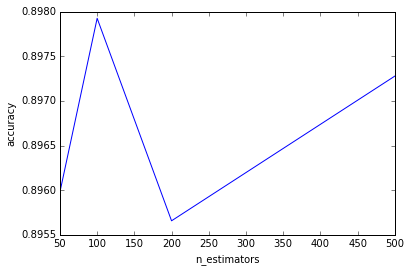

In [37]:
plot_grid_scores(gs_rfc.grid_scores_, 'n_estimators')

/Users/mr/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/mr/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/mr/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(s

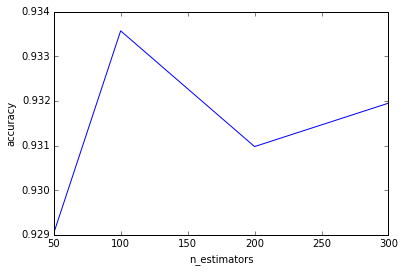

In [43]:
gs_rfc.fit(X_trans, to_2class(y))
plot_grid_scores(gs_rfc.grid_scores_, 'n_estimators')

In [50]:
mal_df = train_df[train_df['class'] != 'None']

In [51]:
X_mal = X_trans[mal_df.index]
y_mal = y[mal_df.index]

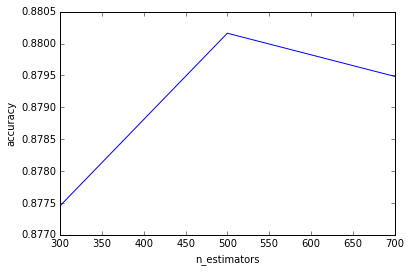

In [55]:
param_grid = {'n_estimators':[300, 500, 700]}
gs_rfc = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
gs_rfc.fit(X_mal, y_mal)
plot_grid_scores(gs_rfc.grid_scores_, 'n_estimators')

## Two-stage classifier

In [57]:
rfc1 = RFC(n_estimators=100, n_jobs=-1)
rfc2 = RFC(n_estimators=500, n_jobs=-1)

In [58]:
def create_split_mask(n_samples, train_size=0.8):
    train, test = train_test_split(range(n_samples), train_size=train_size)
    mask = np.ones(n_samples, dtype='int')
    mask[train] = 1
    mask[test] = 0
    mask = (mask==1)
    return mask

In [59]:
mask = create_split_mask(X.shape[0])

In [78]:
train1_df = train_df[mask]
val1_df = train_df[-mask]
mal_df = train1_df[train1_df['class'] != 'None']

/Users/mr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  from ipykernel import kernelapp as app


In [74]:
X_train1 = X_trans[train_train_df.index]
y_train1 = y[train_train_df.index]

In [77]:
X_train2 = X_trans[train_mal_df.index]
y_train2 = y[train_mal_df.index]

In [109]:
rfc1 = RFC(n_estimators=100, n_jobs=-1)
y_train1 = to_2class(y_train1)
rfc1.fit(X_train1, y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
rfc1.score(X_train1, y_train1)

0.99351701782820101

In [80]:
rfc2 = RFC(n_estimators=500, n_jobs=-1)
rfc2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
rfc2.score(X_train2, y_train2)

0.99157540016849199

In [128]:
predictions = []
for x in X_train1:
    y = rfc1.predict([x])
    if y == 'Mal':
        y = rfc2.predict([x])
    predictions.append(y)

In [135]:
metrics.accuracy_score(train_df['class'][mask], predictions)

0.99189627228525123

In [145]:
X_val = X_trans[train_val_df.index]

In [149]:
val_predictions = []
for x in X_val:
    y = rfc1.predict([x])
    if y == 'Mal':
        y = rfc2.predict([x])
    val_predictions.append(y)

In [150]:
metrics.accuracy_score(train_df['class'][-mask], val_predictions)

/Users/mr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':


0.90938511326860838

## Submission

In [157]:
X_train_2class = X_trans
y_train_2class = to_2class(y)
rfc1.fit(X_train_2class, y_train_2class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [158]:
mal_df = train_df[train_df['class'] != 'None']
X_train_mal = X_trans[mal_df.index]
y_train_mal = y[mal_df.index]
rfc2.fit(X_train_mal, y_train_mal)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [163]:
test_ids_classes, test_trees = read_files('test')

In [164]:
test_df = pd.DataFrame.from_records(test_ids_classes, columns=['id','class'])  
test_df.head()

,id,class
0,0015c8c9ff02fea9d0f45692b9eebfb4abff4e42f,X
1,001f298a534ae4b0db7f2707169250aa215c3b5f2,X
2,001f5fdaaa8bbe20303527198d09a30bb7ca3eb50,X
3,002ca2c41b649f85c05ae30013436781a932fecc6,X
4,003e109543b4ea22d2bcc1ec309bf2fd34e9a1a1d,X


In [165]:
test_calls = get_calls(test_trees)

In [167]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
all_calls = test_calls + train_calls
vectorizer.fit([' '.join(doc) for doc in all_calls])

In [168]:
tfidf_train = vectorizer.transform([' '.join(doc) for doc in train_calls])

In [173]:
X_train = pd.DataFrame(tfidf_train.toarray(), columns=vectorizer.get_feature_names())
y_train = train_df['class']

In [170]:
tfidf_test = vectorizer.transform([' '.join(doc) for doc in test_calls])

In [171]:
X_test = pd.DataFrame(tfidf_test.toarray(), columns=vectorizer.get_feature_names())

In [172]:
print X_train.shape
print X_test.shape

(3086, 21603)
(3724, 21603)


In [174]:
rfc1 = RFC(n_estimators=100)
y_train_2class = to_2class(y)
rfc1.fit(X_train, y_train_2class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [181]:
rfc2 = RFC(n_estimators=500)
mal_df = train_df[train_df['class'] != 'None']
X_train_mal = X_train[X_train.index.isin(mal_df.index)]
y_train_mal = y_train[mal_df.index]
rfc2.fit(X_train_mal, y_train_mal)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [202]:
test_predictions = []
for x in X_test.as_matrix():
    y_hat = rfc1.predict([x])
    if y_hat == 'Mal':
        y_hat = rfc2.predict([x])
    test_predictions.append(malware_classes.index(y_hat))

In [196]:
test_ids = [id_class[0] for id_class in test_ids_classes]

In [203]:
write_predictions(test_predictions, test_ids, 'predictions1')